In [9]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

def detect_longest_line_and_rotate_to_vertical(image):
    # 將影像轉為灰階並進行高斯模糊
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)  # 輕微模糊以減少雜訊

    plt.figure(figsize=(1, 1))
    plt.imshow(blurred)
    # 使用Canny邊緣檢測
    edges = cv2.Canny(blurred, 30, 10)

    plt.figure(figsize=(1, 1))
    plt.imshow(edges)
    
    # 使用霍夫直線變換來僅檢測較長的刻線
    min_line_length = 10  # 設定最小線長，避免檢測到過短的刻線
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi / 180, threshold=30, minLineLength=min_line_length, maxLineGap=5)
    
    # 檢查是否找到刻線
    if lines is not None:
        longest_line = None
        max_length = 0
        
        # 遍歷找到最長的刻線
        for line in lines:
            x1, y1, x2, y2 = line[0]
            length = (x2 - x1) ** 2 + (y2 - y1) ** 2  # 使用平方長度避免開根號，提高效率
            
            # 若找到更長的線則更新
            if length > max_length:
                max_length = length
                longest_line = (x1, y1, x2, y2)
            
            # 優化：如果發現非常長的線，可以考慮直接結束循環
            if max_length > min_line_length ** 2 * 4:  # 假設一條足夠長的線
                break
        
        if longest_line is not None:
            x1, y1, x2, y2 = longest_line
            # 計算最長刻線的角度
            angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
            print(f"最長刻線的角度: {angle}°")
            
            # 計算旋轉角度，使刻線垂直
            rotation_angle = -(90 + angle) if angle > 0 else -(90 + angle)
            
            # 取得旋轉矩陣並進行旋轉
            (h, w) = image.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
            rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
            
            return rotated
    
    print("未找到刻線")
    return image  # 若無檢測到任何刻線，返回原圖


最長刻線的角度: -90.0°


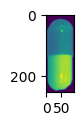

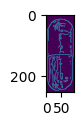

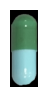

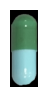

In [11]:
# 載入測試影像
image = cv2.imread('TestImg/capsule/2/A.png')

# 檢測刻線並進行旋轉校正
result = detect_longest_line_and_rotate_to_vertical(image)

plt.figure(figsize=(1, 1))
plt.imshow(image)
plt.axis('off')  # 隱藏座標軸
plt.show()

plt.figure(figsize=(1, 1))
plt.imshow(result)
plt.axis('off')  # 隱藏座標軸
plt.show()

In [5]:
import cv2
import numpy as np

def rotate_image(image, angle):
    """根據指定角度旋轉影像"""
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, matrix, (w, h))
    return rotated

def determine_best_orientation(image_path):
    # 讀取影像
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return "無法讀取影像"

    # 使用Canny邊緣檢測來識別輪廓
    edges = cv2.Canny(img, 30, 10)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return "未識別到膠囊輪廓"

    # 只取最大輪廓
    max_contour = max(contours, key=cv2.contourArea)

    # 擬合形狀，根據邊數來分類
    epsilon = 0.04 * cv2.arcLength(max_contour, True)
    approx = cv2.approxPolyDP(max_contour, epsilon, True)

    # 根據頂點數判斷形狀
    num_sides = len(approx)
    
    # 判斷形狀並決定旋轉角度
    if num_sides == 3:
        # 藥丸形狀 (三角形)：找到重心後對齊某個頂點
        points = np.array(approx).reshape(-1, 2)
        center = np.mean(points, axis=0)
        angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])
        rotation_angle = np.degrees(np.min(angles))  # 選擇最小的角度，使頂點朝上
        return "藥丸形膠囊 (三角形) - 旋轉至頂點朝上", rotation_angle
    elif num_sides == 4:
        # 藥丸形狀 (四邊形)：將其旋轉到任意對稱角度
        points = np.array(approx).reshape(-1, 2)
        edge_vector = points[1] - points[0]
        angle = np.arctan2(edge_vector[1], edge_vector[0])  # 計算邊的角度
        rotation_angle = np.degrees(angle)
        return "藥丸形膠囊 (四邊形) - 旋轉至對齊角度", rotation_angle
    elif num_sides == 5:
        # 藥丸形狀 (五邊形)：任意對稱軸旋轉
        rotation_angle = 0  # 假設對稱軸朝上
        return "藥丸形膠囊 (五邊形) - 旋轉至對齊角度", rotation_angle
    elif num_sides == 6:
        # 藥丸形狀 (六邊形)：選擇對稱角度
        rotation_angle = 0
        return "藥丸形膠囊 (六邊形) - 旋轉至對齊角度", rotation_angle
    elif num_sides == 8:
        # 藥丸形狀 (八邊形)：可以選擇對稱角度
        rotation_angle = 0
        return "藥丸形膠囊 (八邊形) - 旋轉至對齊角度", rotation_angle
    elif num_sides > 8:  # 藥丸形狀 (七邊形或更高邊數)
        rotation_angle = 0
        return "藥丸形膠囊 - 旋轉至對齊角度", rotation_angle
    else:
        # 圓形或橢圓形
        # 偵測圓形或橢圓形
        # 計算形狀的圓度，圓形接近1，橢圓形則小於1
        aspect_ratio = float(img.shape[0]) / img.shape[1]
        if aspect_ratio < 1.2 and aspect_ratio > 0.8:  # 圓形判斷範圍
            rotation_angle = 0  # 圓形無需旋轉
            return "圓形膠囊 - 無需旋轉", rotation_angle
        else:  # 橢圓形
            rotation_angle = 0  # 橢圓形根據長軸方向旋轉
            return "橢圓形膠囊 - 旋轉至長軸方向", rotation_angle

In [6]:
# 假設我們有影像文件
image_path = 'TestImg/pill/2/Sample_9_1_A_W.png'
orientation, rotation_angle = determine_best_orientation(image_path)
print(f"推薦擺放方式: {orientation}")

# 旋轉影像
img = cv2.imread(image_path)
rotated_img = rotate_image(img, rotation_angle)

# 顯示旋轉後的結果
cv2.imshow("Rotated Capsule", rotated_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

推薦擺放方式: 藥丸形膠囊 (四邊形) - 旋轉至對齊角度
